# Прогнозирование оттока клиентов

## Оглавление
* [Подготовка к работе](#по_кр)
* [Открытие, изучение и подготовка данных](#от_из)
* [Исследование моделей](#ис_мо)
    * [`LogisiticRegression`](#ло_ре)
    * [`DecisionTreeClassifier`](#де_тр)
    * [`RandomForestClassifier`](#ра_фо)
    * [`DummyClassifier`](#да_кл)
    * [Заключение](#за)
* [`SMOTE`](#см)
* [Тестирование лучшей модели](#те_лу)
* [Выводы](#вы)

## Подготовка к работе <a class="anchor" id="по_кр"></a>

Импортируем нужные библиотеки, зададим значения параметров и опишем функции.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    auc, roc_auc_score, roc_curve, confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 

from imblearn.over_sampling import SMOTE
from collections import Counter

RANDOM_STATE = 914
np.random.seed(RANDOM_STATE)

In [2]:
# функция для построения зависимости точности, полноты и f1_score от порога классификации
# и вывода набора метрик с лучшим показателем f1_score

def metrics_plot(X_val, model):
    
    prob_val = model.predict_proba(X_val)[:, 1]
    metrics = pd.DataFrame(columns=['Порог', 'Точность', 'Полнота', 'F1'])

    for threshold in np.arange(0, 1, 0.05):
        y_pred = list(map(float, prob_val > threshold))
    
        metrics = pd.concat([metrics, pd.DataFrame({
                                      'Порог': [threshold], 
                                      'Точность': [precision_score(y_val, y_pred)], 
                                      'Полнота': [recall_score(y_val, y_pred)], 
                                      'F1': [f1_score(y_val, y_pred)]})
                            ], ignore_index=True)
        

    metrics.plot(x='Порог', y=['Точность','Полнота','F1'], grid=True, figsize=(8,5),
        ylabel='Значение метрики', 
        title=f'Зависимость метрик от порога классификации для {model.__class__.__name__}');
    plt.show()
    
    display(Markdown('Наилучший порог по f1-мере:'))
    display(metrics[metrics['F1'] == max(metrics['F1'])])
    

In [3]:
# функция рассчёта ROC-AUC, построения кривой ROC-AUC и вывода значения порога
# при котором tpr классификатора максильно отличается от tpr случайного классификатора

def plot_roc_curve(X_val, model):
    
    y_prob = model.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='tab:orange', label='ROC-AUC = %0.4f' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'lower right')
    plt.grid()
    plt.show()
    
    delta = tpr-fpr
    max_index, max_value = max(enumerate(delta), key=lambda pair: pair[1])
    display(Markdown(f'Наилучший порог: **{thresholds[max_index]:.4}**'))   

In [4]:
# фунция для обучения моделей LogisiticRegression и DecisionTreeClassifier с заданными 
# гиперпараметрами и получения предсказаний и сохранения результатов в датафрейм

def fit_result(model, params, X_train, y_train, X_val, y_val, df):
    model.fit(X_train, y_train)
    
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    
    f1_train = f1_score(y_train, predictions_train)
    f1_val = f1_score(y_val, predictions_val)

    df = pd.concat([df, pd.DataFrame({
                        params[0]:[globals()[params[0]]],
                       'f1_train':[f1_train],
                       'f1_val':[f1_val]})
                   ],ignore_index=True)
        
    return df

In [5]:
# функция для отображения графиков зависимости метрики от гиперпараметров 
# для LogisiticRegression и DecisionTreeClassifier

def pair_plot(data, p1):

    sns.lineplot(x=p1, y='f1_train', data=data, palette='colorblind', label='train F1 Score')
    sns.lineplot(x=p1, y='f1_val', data=data, palette='colorblind', label='val F1 Score')
    plt.grid(True, linestyle='--')
    plt.show()

    display(Markdown('**Наилучший набор гиперпараметров:**'))
    display(data[data['f1_val'] == max(data['f1_val'])].head(1))

In [6]:
# фунция для обучения модели RandomForestClassifier с заданными гиперпараметрами,
# получения предсказаний и сохранения результатов в датафрейм

def fit_result_RFC(model, params, X_train, y_train, X_val, y_val, df):
    model.fit(X_train, y_train)
    
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    
    f1_train = f1_score(y_train, predictions_train)
    f1_val = f1_score(y_val, predictions_val)

    df = pd.concat([df, pd.DataFrame({
                        params[0]:[globals()[params[0]]],
                        params[1]:[globals()[params[1]]],
                       'f1_train':[f1_train],
                       'f1_val':[f1_val]})
                   ],ignore_index=True)
        
    return df

In [7]:
# функция для отображения графиков зависимости метрики от гиперпараметров
# для RandomForestClassifier

def pair_plot_RFC(data, p1, p2):
    fig, ax = plt.subplots(2, 2, figsize=(12,7))
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    sns.pointplot(x=p1, y='f1_train', hue=p2, data=data, palette='colorblind', linewidth=1, ax=ax[0,0])
    ax[0, 0].grid(True, linestyle='--')

    sns.pointplot(x=p1, y='f1_val', hue=p2, data=data, palette='colorblind', linewidth=1,  ax=ax[0, 1])
    ax[0, 1].grid(True, linestyle='--')

    sns.pointplot(x=p2, y='f1_train', hue=p1, data=data, palette='colorblind', linewidth=1, ax=ax[1, 0])
    ax[1, 0].grid(True, linestyle='--')

    sns.pointplot(x=p2, y='f1_val', hue=p1, data=data, palette='colorblind', linewidth=1, ax=ax[1, 1])
    ax[1, 1].grid(True, linestyle='--')
    
    plt.show()

    display(Markdown('**Наилучший набор гиперпараметров:**'))
    display(data[data['f1_val'] == max(data['f1_val'])].head(1))

## Открытие, изучение и подготовка данных <a class="anchor" id="от_из"></a>

Откроем `csv` файл, сохраним его в переменную `data` и изучим основные характеристики данных.

In [8]:
data = pd.read_csv('datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [10]:
data.describe().round(4)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.0000,1.000000e+04,10000.0000,10000.0000,9091.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000
mean,5000.5000,1.569094e+07,650.5288,38.9218,4.9977,76485.8893,1.5302,0.7055,0.5151,100090.2399,0.2037
std,2886.8957,7.193619e+04,96.6533,10.4878,2.8947,62397.4052,0.5817,0.4558,0.4998,57510.4928,0.4028
min,1.0000,1.556570e+07,350.0000,18.0000,0.0000,0.0000,1.0000,0.0000,0.0000,11.5800,0.0000
25%,2500.7500,1.562853e+07,584.0000,32.0000,2.0000,0.0000,1.0000,0.0000,0.0000,51002.1100,0.0000
50%,5000.5000,1.569074e+07,652.0000,37.0000,5.0000,97198.5400,1.0000,1.0000,1.0000,100193.9150,0.0000
75%,7500.2500,1.575323e+07,718.0000,44.0000,7.0000,127644.2400,2.0000,1.0000,1.0000,149388.2475,0.0000
max,10000.0000,1.581569e+07,850.0000,92.0000,10.0000,250898.0900,4.0000,1.0000,1.0000,199992.4800,1.0000


Сразу видно, что названия столбцов начинаются с заглавной буквы. Так же видны пропуски в `Tenure`. И наши данные имеют разные диапазоны значений. Отдельно выделим то, что в данных есть и категориальные признаки, а некоторые признаки, такие как `CustomerId`, `Surname` и `RowNumber` не нужны для обучения моделей. Начнём с названий столбцов.

In [11]:
data.columns = [x.lower() for x in data.columns]

Рассмотрим значения, которые находятся в `tenure`.

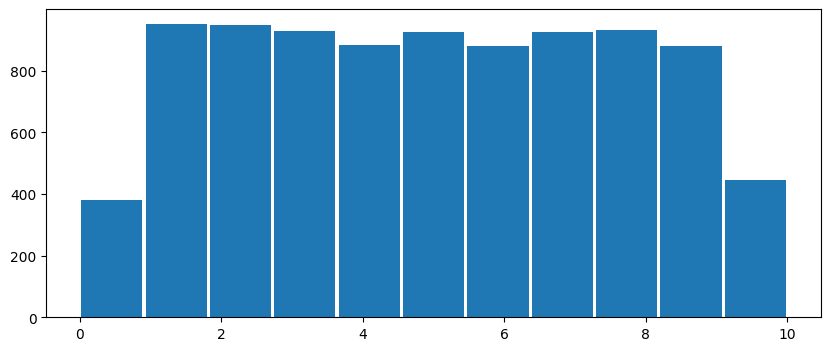

In [12]:
plt.figure(figsize=(10,4))
plt.hist(data['tenure'], bins = 11, rwidth=0.95);

Данные распределены равномерно. Заполним пропуски значениями из столбца с учётом вероятности появления каждого значения в выборке, чтобы не повлиять на распределение данных в столбце.

In [13]:
mean = data['tenure'].mean()
std = data['tenure'].std()
n_missing = data['tenure'].isnull().sum()
data.loc[data['tenure'].isnull(), 'tenure'] = np.random.normal(mean, std, n_missing)

print(f'Среднее заполненного столбца: {data.tenure.mean():.4f}')
print(f'Дисперсия заполненного столбца: {data.tenure.std():.4f}')

Среднее заполненного столбца: 4.9942
Дисперсия заполненного столбца: 2.8989


Мы заполнили пропуски в столбце `tenure`, при этом характеристики распределения не поменялись. Посмотрим на баланс целевого класса.

In [14]:
data['exited'].value_counts(normalize=True)

exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Виден значительный дисбаланс. Учтём это на будущее. Разделим данные на признаки и целевой признак, удалив `CustomerId`, `Surname` и `RowNumber`.

In [15]:
X = data.drop(['surname', 'customerid', 'rownumber', 'exited'], axis=1)
y = data['exited']

Преобразуем категориальные признаки.

In [16]:
cat_columns = ['geography', 'gender']

ohe = OneHotEncoder(sparse=False, drop='first')
X_ohe = ohe.fit_transform(X[cat_columns])
X[ohe.get_feature_names_out()] = X_ohe 
X.drop(columns=cat_columns, inplace=True)

X.sample(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
2833,683,40,8.0,0.00,1,1,0,75848.22,0.0,1.0,1.0
8071,609,48,1.0,108019.27,3,1,1,184524.65,0.0,0.0,1.0
5161,842,46,9.0,0.00,1,0,0,17268.02,0.0,1.0,1.0
7118,715,32,8.0,175307.32,1,1,0,187051.23,0.0,0.0,1.0
3247,791,25,7.0,0.00,1,1,0,89666.28,0.0,1.0,1.0


Осталось разбить датасет на обучающие признаки и целевой признак, затем на тренировочную, валидационную и тестовые выборки в соотношении 3:1:1. Тренировочная выборка будет использоваться для обучения моделей, валидационная для тестирования моделей во время обучения. Тестовую выборку отложем до самого последнего момента, когда лучшая модель уже будет выбрана. Такой сценарий наиболее приближён к реальному, когда тестовая выборка зачастую недоступна при разбработке моделей и истинную метрику можно получить уже после того, как модель будет выбрана и обучена.
Затем приведём данные к одному диапазону значений с помощью `StandardScaler()`. При этом обучать трансформер будем только на тренировочной выборке во избежание утечки.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

In [18]:
std_scaler = StandardScaler()
std_scaler.fit(X_train) 

X_train_scaled = std_scaler.transform(X_train)
X_val_scaled = std_scaler.transform(X_val)
X_test_scaled = std_scaler.transform(X_test)

Подготовка данных завершена, приступим к изучению моделей.

## Исследование моделей <a class="anchor" id="ис_мо"></a>

В данном исследовании будут рассмотрены `LogisiticRegression`, `DecisionTreeClassifier` и `RandomForestClassifier`.

### `LogisiticRegression` <a class="anchor" id="ло_ре"></a>

Подберём оптимальное значение параметра `max_iter`, исследуем поведение `точности`, `полноты` и `f1-меры` в зависимости от порога у лучшей модели и построим `ROC-AUC` кривую. Учитывая, что в наших данных присуствует дисбаланс, установим `class_weight='balanced'`.

In [19]:
params_LR = ['max_iter']
f1_LR = pd.DataFrame(
    columns=[*params_LR, 'f1_train', 'f1_val']
)

for max_iter in range(1, 102, 5):
    model_LR = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=max_iter)  
    f1_LR = fit_result(model_LR, params_LR, X_train_scaled, y_train, X_val_scaled, y_val, f1_LR)    

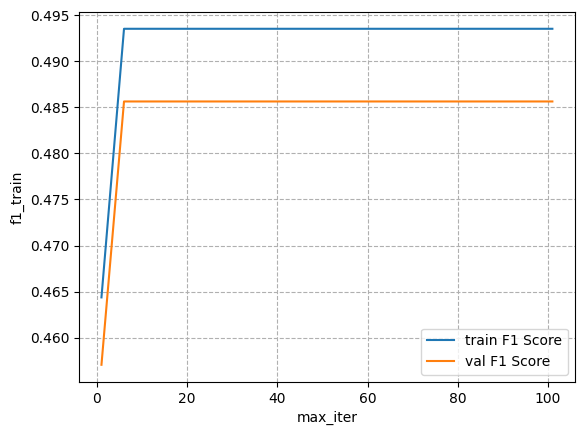

**Наилучший набор гиперпараметров:**

,max_iter,f1_train,f1_val
1,6,0.493529,0.48564


In [20]:
pair_plot(f1_LR, 'max_iter')

`LogisiticRegression` практически сразу достигает максимальной метрики при `max_iter = 6`.

In [21]:
model_LR_best = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=6)
model_LR_best.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=6, random_state=914)

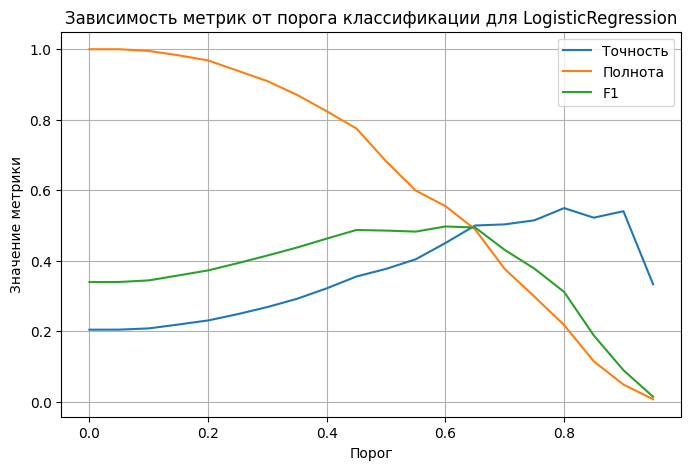

Наилучший порог по f1-мере:

,Порог,Точность,Полнота,F1
12,0.6,0.450397,0.555012,0.497262


In [22]:
metrics_plot(X_val_scaled, model_LR_best)

* При нулевом пороге все ответы попадают в положительный класс, `false negative` отсутствуют, поэтому `полнота` равняется единице. При повышении порога она уменьшается до **0**, когда не остаёся `true positive` ответов.
* `Точность` при нулевом пороге равняется отношению классов таргета в выборке и принимает значение **0.2**. Затем растёт до примерно **0.55** при **пороге 0.8**. При **пороге стремящемся к 1** `точность` может быть рассчитана только приблизительно, из-за увеличения неопределённости `0/(0+0)` при отсутствии положительных классов. Теоретически, `точность` должна возрастать, однако мы видим противоположный эффект. Возможно это связано с тем, что `LogisiticRegression` впринципе плохо предсказывает, и даёт некоторое значение `false positive` даже при **пороге около 1**. 
* `f1-мера` принимает максимальное **значение 0.5** при **пороге 0.6**. Подбор порога дал выигрыш лишь в **0.012**.

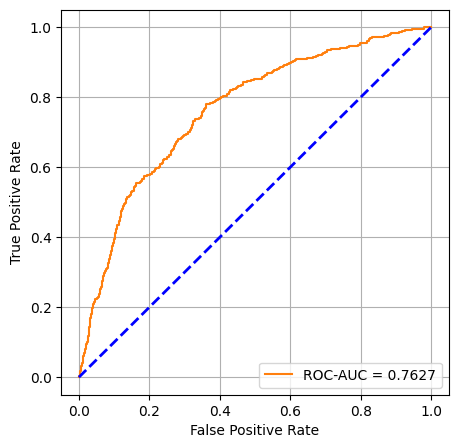

Наилучший порог: **0.4489**

In [23]:
plot_roc_curve(X_val_scaled, model_LR_best)

График `ROC` кривой полностью согласуется с теорией:
* При пороге близком к **1** (около точки (0,0)) находится крайне мало объектов, которые будут отнесены к `positive`, `TPR` и `FPR` имеют близкие к **0** числители, но ненулевые знаменатели.
* При уменьшении порога появляется больше положительных объектов, `TPR` и `FPR` растут. При этом `TPR` растёт быстрее, чем `FPR`, `AUC` кривая находится над линией случайного определения классов, что говорит о том, что наш классификатор имеет "предсказательную силу" и предсказывает лучше, чем ошибается.
* График `AUC` приходит в точку (1,1) при нулевом пороге, когда все объекты классифицируются как `positive`, `TPR` и `FPR` принимают вид **1/1** и ровняются **1**.
* Согласно `AUC` кривой наилучшее значение порога классификации: **0.449**.
* `ROC-AUC` имеет не очень большое значение **0.7627**.
* Наилучший порог определяется как порог, при котором `TPR` модели максимально отличается от случайного классификатора.

### `DecisionTreeClassifier` <a class="anchor" id="де_тр"></a> 

Проведём аналогичный анализ для `DecisionTreeClassifier` с подобранным гиперпараметром `max_depth`.

In [24]:
params_DTC = ['max_depth']
f1_DTC = pd.DataFrame(
    columns=[*params_DTC, 'f1_train', 'f1_val']
)

for max_depth in range(1, 32, 2):
    model_DTC = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced', max_depth=max_depth) 
    f1_DTC = fit_result(model_DTC, params_DTC, X_train, y_train, X_val, y_val, f1_DTC)    

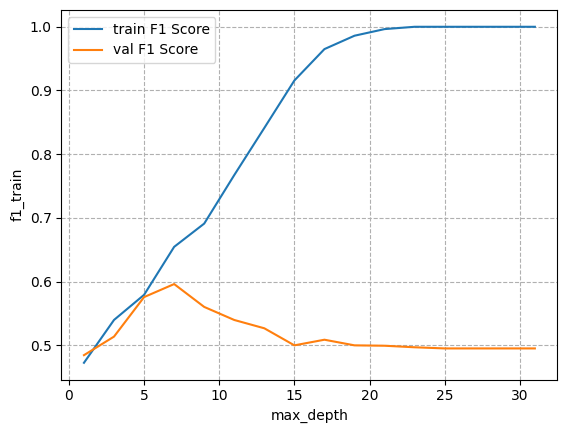

**Наилучший набор гиперпараметров:**

,max_depth,f1_train,f1_val
3,7,0.654584,0.596195


In [25]:
pair_plot(f1_DTC, 'max_depth')

Видим ожидаемое поведение: метрика растёт и на тренировочной, и на валидационной выборке до определённого момента, затем наступает переобучение и метрика на тестовой выборке падает. Установим `max_depth=7`.

In [26]:
model_DTC_best = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced', max_depth=7)
model_DTC_best.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=7, random_state=914)

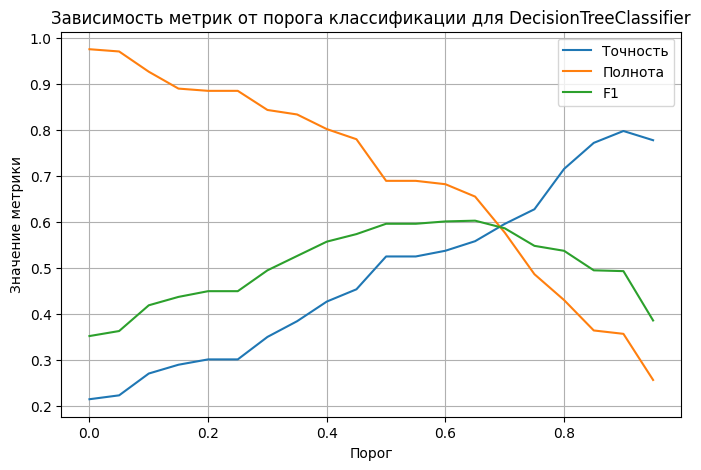

Наилучший порог по f1-мере:

,Порог,Точность,Полнота,F1
13,0.65,0.558333,0.655257,0.602925


In [27]:
metrics_plot(X_val, model_DTC_best)

График повторяется как у `LogisiticRegression` с той разницей, что `точность` растёт до **0.8** и практически не уменьшается при **пороге 1**, а `f1_мера` принимает максимальное значение равное **0.6** при пороге **0.65**. Подбор порога так же дал выигрыш в `f1-мере` равный **0.008**.

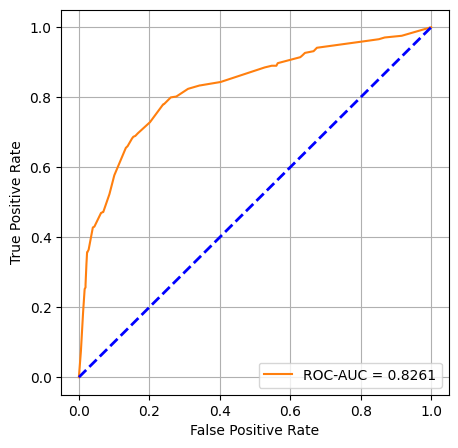

Наилучший порог: **0.4643**

In [28]:
plot_roc_curve(X_val, model_DTC_best)

`AUC` кривая `DecisionTreeClassifier` расположена выше и левее, чем у `LogisiticRegression`, а `ROC_AUC` равен **0.826**, что говорит о том, что `DecisionTreeClassifier` лучше справляется с задачей.

Посмотрим на то, как выглядят первые 3 узла дерева.

In [29]:
fn=X.columns
cn=['not exited', 'exited']

dot_data = tree.export_graphviz(model_DTC_best, out_file=None, 
                      feature_names=fn,  
                      class_names=cn,  
                      filled=True, rounded=True,
                      max_depth=2,
                      special_characters=True) 

graph = graphviz.Source(dot_data)

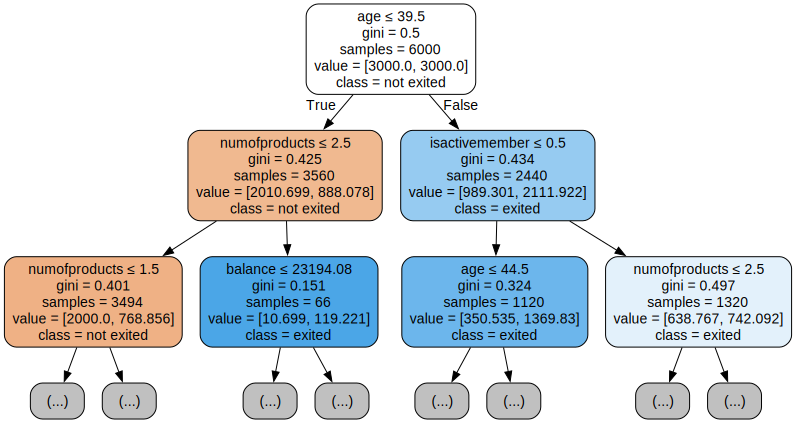

In [30]:
graph

1. К сожалению, параметр `class_weight='balanced'` затрудняет чтение диаграммы, сумма классов в `value` не равно значению в `samples`, а расчёт `gini`, видимо, происходит не совсем по алгоритму `1 - сумма квадратов вероятностей`.
2. Самое большое разделение происходит по `age`, в зависимости от того, больше или меньше возраст, чем **39.5** лет. Это самый важный признак.

### `RandomForestClassifier` <a class="anchor" id="ра_фо"></a> 

Рассмотрим классификацию с помощью `RandomForestClassifier`, подбирая `max_depth` и `n_estimators`.

In [31]:
params = ['max_depth', 'n_est']
f1_RFC = pd.DataFrame(
    columns=[*params, 'f1_train', 'f1_val']
)

for max_depth in range(1, 30, 4):
    for n_est in range(1, 52, 10):
        model_RFC = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_estimators=n_est, max_depth=max_depth) 
        f1_RFC = fit_result_RFC(model_RFC, params, X_train, y_train, X_val, y_val, f1_RFC)    

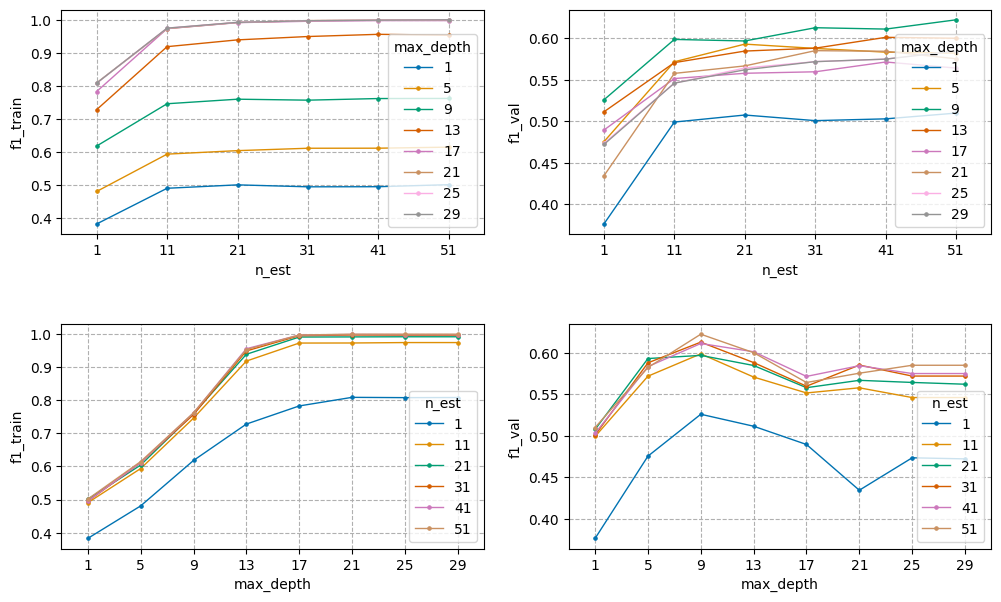

**Наилучший набор гиперпараметров:**

,max_depth,n_est,f1_train,f1_val
17,9,51,0.762162,0.622222


In [32]:
pair_plot_RFC(f1_RFC, 'n_est', 'max_depth')

Налучший набор параметров `max_depth = 9` и `n_est = 51` позволяет достичь `f1_val` значение **0.622**.

In [33]:
model_RFC_best = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_estimators=51, max_depth=9)
model_RFC_best.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=51,
                       random_state=914)

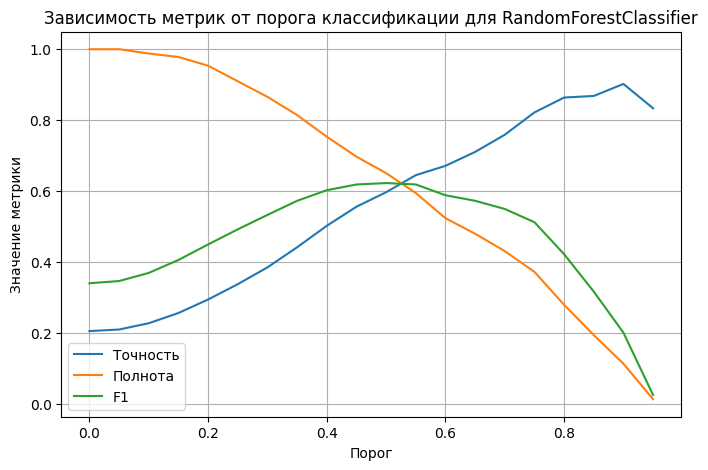

Наилучший порог по f1-мере:

,Порог,Точность,Полнота,F1
10,0.5,0.596413,0.650367,0.622222


In [34]:
metrics_plot(X_val, model_RFC_best)

Оптимальный по `f1-мере` порог равен **0.5**.

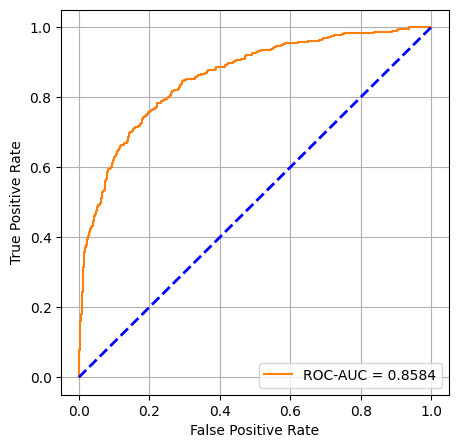

Наилучший порог: **0.3967**

In [35]:
plot_roc_curve(X_val, model_RFC_best)

Теперь нужно сравнить работу наших моделей с простым классификатором.

### `DummyClassifier` <a class="anchor" id="да_кл"></a>

In [36]:
model_DUMMY = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
model_DUMMY.fit(X_train, y_train)
predict_DUMMY = model_DUMMY.predict(X_val)
display(Markdown(f'f1_score Dummy классификатора: **{f1_score(predict_DUMMY, y_val).round(4)}**'))

f1_score Dummy классификатора: **0.212**

Метрики наших моделей заметно лучше. Это говорит о том, что наши модели действительно пытаются найти закономерности в данных и у них это получается в некоторой степени.

### Заключение <a class="anchor" id="за"></a>

1. Наилучшая модель из трёх рассмотренных: `RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_estimators=51, max_depth=9)`
2. `f1-мера` на валидационной выборке: **0.622** c порогом **0.5**.
3. `ROC-AUC`: **0.858**.

Перед тестированием дополнительно рассмотрим ещё один метод борьбы с дисбалансом.

# SMOTE <a class="anchor" id="см"></a>

`SMOTE` дозаполняет нехватку данных недостающего класса, создавая новые объекты, которые находятся в признаковом пространстве между уже имеющимися. Применим его к нашим данным и обучим `RandomForestClassifier`, убрав параметр `class_weight='balanced'`.

In [37]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
print("Original dataset:", sorted(Counter(y).items()))
print("Sampled dataset:", sorted(Counter(y_resampled).items()))

Original dataset: [(0, 7963), (1, 2037)]
Sampled dataset: [(0, 4767), (1, 4767)]


In [38]:
params = ['max_depth', 'n_est']
f1_RFC_SMOTE = pd.DataFrame(
    columns=[*params, 'f1_train', 'f1_val']
)

for max_depth in range(1, 30, 4):
    for n_est in range(1, 52, 10):
        model_RFC_SMOTE = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=n_est, max_depth=max_depth) 
        f1_RFC_SMOTE = fit_result_RFC(model_RFC_SMOTE, params, X_resampled, y_resampled, X_val, y_val, f1_RFC_SMOTE)    

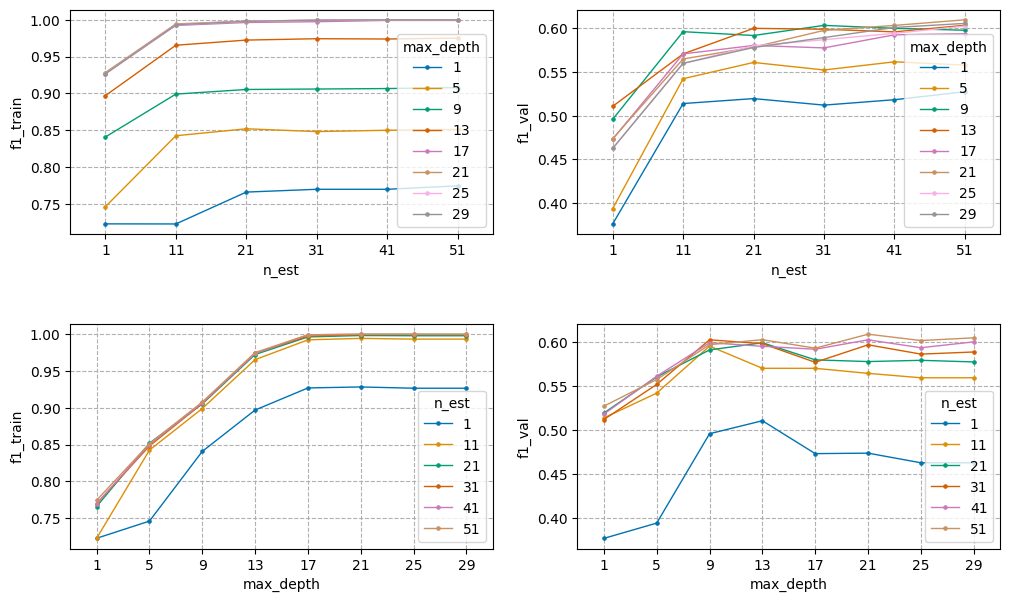

**Наилучший набор гиперпараметров:**

,max_depth,n_est,f1_train,f1_val
35,21,51,1.0,0.609254


In [39]:
pair_plot_RFC(f1_RFC_SMOTE, 'n_est', 'max_depth')

In [40]:
model_RFC_SMOTE = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=21, max_depth=51)
model_RFC_SMOTE.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=51, n_estimators=21, random_state=914)

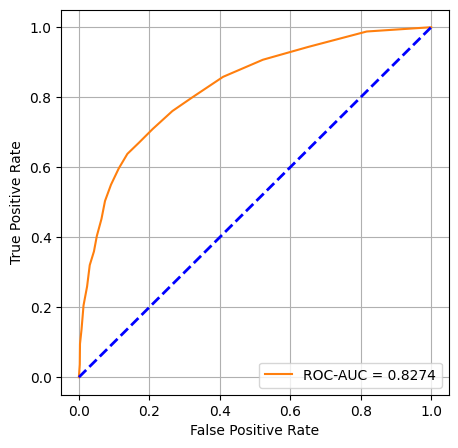

Наилучший порог: **0.4286**

In [41]:
plot_roc_curve(X_val, model_RFC_SMOTE)

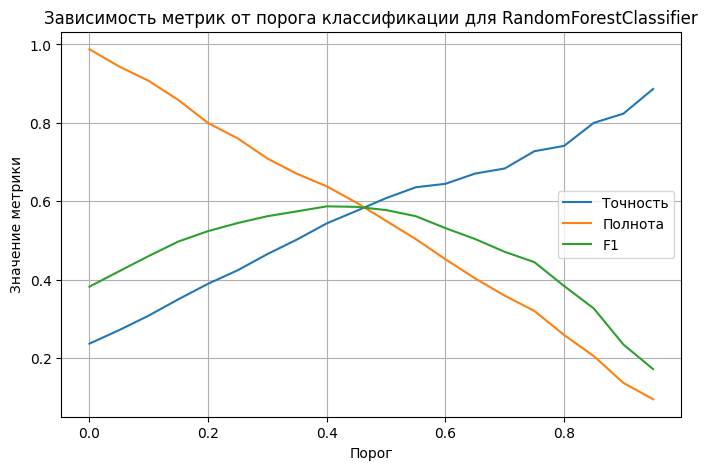

Наилучший порог по f1-мере:

,Порог,Точность,Полнота,F1
8,0.4,0.54375,0.638142,0.587177


In [42]:
metrics_plot(X_val, model_RFC_SMOTE)

Результаты стали даже немного хуже. Остановимся на использовании `class_weight='balanced'`.

## Тестирование лучшей модели <a class="anchor" id="те_лу"></a>

Протестируем лучшую модель и проанализиурем её ответы.

In [43]:
display(Markdown(f'f1-мера лучшей модели: **{f1_score(y_test, model_RFC_best.predict(X_test)):.4}**'))   

f1-мера лучшей модели: **0.6119**

Text(0.5, 1.0, 'Матрица ошибок')

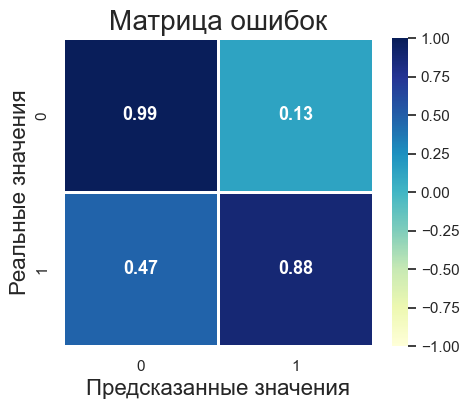

In [44]:
conf_matrix = confusion_matrix(y_val, model_RFC_best.predict(X_val))

sns.set(rc={'figure.figsize':(5,4)})

sns.heatmap(normalize(conf_matrix),
            vmin=-1,
            vmax=1,
            cmap="YlGnBu",
            annot=True,
            annot_kws={'fontsize':13, 'fontweight':'bold'},
            fmt='.2f',
            linewidths=1,);
plt.xlabel('Предсказанные значения', fontsize=16)
plt.ylabel('Реальные значения', fontsize=16)
plt.title('Матрица ошибок', fontsize=20)

Модель практически всегда верно определяет, что *клиент не уйдёт* и чуть хуже *уход клиента*. Понизив порог разделения классов можно увеличить `полноту` предсказания *ухода клиента*. Модель будет распознавать больше клиентов, которые действительно *хотят уйти*, но при этом увеличится количество *ложноположительных* предсказаний.

Text(0.5, 1.0, 'Матрица ошибок')

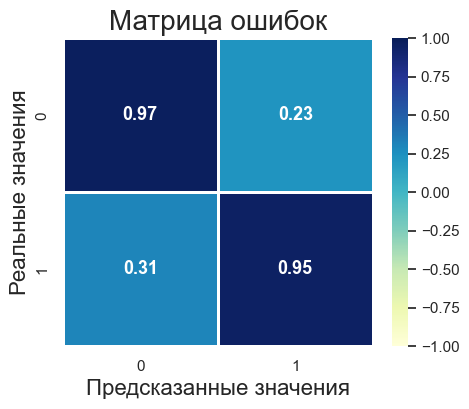

In [45]:
conf_matrix = confusion_matrix(y_val, model_RFC_best.predict_proba(X_val)[:,1]>0.4)

sns.set(rc={'figure.figsize':(5,4)})

sns.heatmap(normalize(conf_matrix),
            vmin=-1,
            vmax=1,
            cmap="YlGnBu",
            annot=True,
            annot_kws={'fontsize':13, 'fontweight':'bold'},
            fmt='.2f',
            linewidths=1,);
plt.xlabel('Предсказанные значения', fontsize=16)
plt.ylabel('Реальные значения', fontsize=16)
plt.title('Матрица ошибок', fontsize=20)

In [46]:
display(Markdown(f'f1-мера лучшей модели: **{f1_score(y_test, model_RFC_best.predict_proba(X_test)[:,1]>0.4):.4}**'))

f1-мера лучшей модели: **0.6016**

## Вывод <a class="anchor" id="вы"></a>

В данном проекте рассмотрены классификаторы `LogisiticRegression`, `DecisionTreeClassifier` и `RandomForestClassifier`. Подготовка данных заключалась в заполнении пропусков в столбце `tenure` с сохранением параметров распределения, преобразовании категориальных переменных с помощью `OneHotEncoder`, подготовки выборов для обучения и тестирования, и создания отдельных выборок с данными, приведёнными к одному диапазону значений с помощью `StandardScaler`.

Для каждой модели исследовано поведение метрик `точность`, `полнота`, `f1-score` и `ROC-AUC` в зависимости от порога классификации, построены графики, выбраны оптимальные значения параметров. Все метрики показали ожидаемое поведение. Для `DecisionTreeClassifier` дополнительно построена схема дерева, из которой видно, что самое большое разделение происходит по `age`, в зависимости от того, больше или меньше возраст, чем **39.5** лет. Это самый важный признак. Результаты сравнены с `DummyClassifier`.

Лучшей моделью признан `RandomForestClassifier` с гиперпараметрами `class_weight='balanced'`,  `n_estimators=51`,  `max_depth=9` и `f1_score` **0.622**. С помощью матрицы ошибок показано, что изменение порога до `0.4` можно увеличить `полноту` предсказания *ухода клиента*. Модель будет распознавать больше клиентов, которые действительно *хотят уйти*, но при этом увеличив количество *ложноположительных* предсказаний.